<a href="https://colab.research.google.com/github/Ascalonic/PyCovid/blob/master/CovidModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

           date location  new_cases  new_deaths  total_cases  total_deaths
911  2020-01-28  Germany        NaN         NaN            1           NaN
912  2020-01-29  Germany        3.0         NaN            4           NaN
913  2020-01-30  Germany        0.0         NaN            4           NaN
914  2020-01-31  Germany        1.0         NaN            5           NaN
915  2020-02-01  Germany        2.0         NaN            7           NaN
Epoch 1/100
 - 2s - loss: 5.0739e-04
Epoch 2/100
 - 0s - loss: 4.9770e-04
Epoch 3/100
 - 0s - loss: 5.1023e-04
Epoch 4/100
 - 0s - loss: 4.8985e-04
Epoch 5/100
 - 0s - loss: 4.8856e-04
Epoch 6/100
 - 0s - loss: 4.9758e-04
Epoch 7/100
 - 0s - loss: 4.7338e-04
Epoch 8/100
 - 0s - loss: 4.7861e-04
Epoch 9/100
 - 0s - loss: 4.7624e-04
Epoch 10/100
 - 0s - loss: 4.8138e-04
Epoch 11/100
 - 0s - loss: 4.5875e-04
Epoch 12/100
 - 0s - loss: 4.7972e-04
Epoch 13/100
 - 0s - loss: 4.6052e-04
Epoch 14/100
 - 0s - loss: 4.5093e-04
Epoch 15/100
 - 0s - loss: 

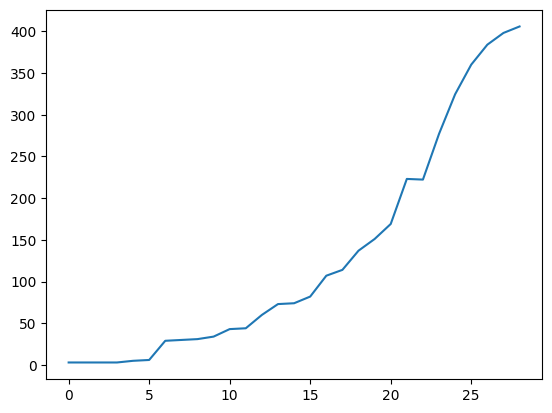

In [9]:
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.optimize import curve_fit ## TODO: use curve fit to fit a function
import fbprophet

# TODO: use LSTM
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

scaler = MinMaxScaler(feature_range=(0, 1))

# re-scale the data from 0 to 1
def RescaleData(dataframe, column_name):
  values = dataframe[column_name].values.reshape(-1, 1)
  values = values.astype('float32')
  global scaler
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  return scaled

## Prediction using purely Time series data from India - Using fb Prophet
def prophetPredict(dataframe):
  dataframe["Date"] = pd.to_datetime(dataframe["Date"], dayfirst=True).dt.strftime('%Y-%m-%d')
  dataframe = dataframe.rename(columns={'Date': 'ds', 'TotalCases': 'y'})
  covid_prophet = fbprophet.Prophet()
  covid_prophet.fit(dataframe)
  covid_forecast = covid_prophet.make_future_dataframe(periods=30, freq='D')
  # Make predictions
  covid_forecast = covid_prophet.predict(covid_forecast)
  covid_prophet.plot(covid_forecast, xlabel = 'Date', ylabel = 'TotalCases')
  plt.title('Total Cases Predicted in India');

def getChinaDataFrame(dataframe):
  is_China = dataframe['location']== 'Germany'
  dataframe = dataframe[is_China]
  print(dataframe.head())
  #dataframe.plot(x='date', y='total_cases')
  #plt.title('China Time series for total cases');
  return dataframe

def createDataset(dataset, look_back = 1):
  dataX, dataY = [], []
  for i in range(len(dataset) - look_back):
    a = dataset[i: (i + look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)


# Load Kerala Demographics from Google sheet
url_kerala_demograph = 'https://raw.githubusercontent.com/Ascalonic/CoronasafeDatasets/master/DemographicsKerala.csv'
df_demograph = pd.read_csv(url_kerala_demograph, header=0)

url_india_timeseries = 'https://raw.githubusercontent.com/Ascalonic/CoronasafeDatasets/master/CoronaTimeSeriesIndia.csv'
df_timeseries = pd.read_csv(url_india_timeseries, header=0)

url_who_dataset = 'https://covid.ourworldindata.org/data/full_data.csv'
df_who_dataset = pd.read_csv(url_who_dataset, header=0)
df_china = getChinaDataFrame(df_who_dataset) #China time series

# Criticality Factors
criticality = {
    'Mild': 0.81,
    'Severe': 0.14,
    'Critical': 0.05
}

# Age based Risk Factors
age_risk = {'Category': ['Low', 'Medium', 'High'], 'MinAge': [0, 50, 80], 'MaxAge': [49, 79, 110]}
df_age_risk = pd.DataFrame(data=age_risk)

# Mortality rate
mortality = {'MinAge': [0, 50, 80], 'MaxAge': [49, 79, 110], 'Percentage': [0.3, 3.1, 8]}
df_mortality = pd.DataFrame(data=mortality)

# df_timeseries.plot(x='Date', y='TotalCases')

# prophetPredict(df_timeseries)

scaled = RescaleData(df_china[1:], 'total_cases') # rescale to (0, 1)
train_size = int(len(scaled) * 0.8)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size, :], scaled[train_size:len(scaled), :]

look_back = 1

## two time steps, [samples, features] structure
trainX, trainY = createDataset(train, look_back)
testX, testY = createDataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

## make prediction on Indian data
indian_scaled = RescaleData(df_timeseries, 'TotalCases') # rescale to (0, 1)

indian_time_step, indian_time_stepY = createDataset(indian_scaled, look_back)
indian_pred = np.reshape(indian_time_step, (indian_time_step.shape[0], 1, indian_time_step.shape[1]))

# predicted = model.predict(indian_pred)
# predicted = scaler.inverse_transform(predicted)

indian_prediction = df_timeseries.copy()['TotalCases'].values

num_prediction = 7
prediction_list = indian_pred[-look_back:]

for _ in range(num_prediction):
    x = prediction_list[-look_back:]
    x = x.reshape((1, look_back, 1))
    predicted = model.predict(x)
    # print(indian_prediction)
    indian_prediction = np.append(indian_prediction, scaler.inverse_transform(predicted)[0][0])
    # print(scaler.inverse_transform(predicted))
    out = predicted[0][0]
    prediction_list = np.append(prediction_list, out)
prediction_list = prediction_list[look_back-1:]

print(indian_prediction)
#.plot(df_china['total_cases'][0:30])
plt.plot(indian_prediction)
plt.show()
